Importin the Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
data=pd.read_csv('Iris Dataset.csv')

In [3]:
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
data.shape

(150, 6)

In [5]:
data.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


In [7]:
data['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Converting labels into numerical using LabelEncoder

In [8]:
label = LabelEncoder()
data['Species'] = label.fit_transform(data['Species'])

In [9]:
data=data.drop('Id',axis=1)

In [10]:
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [11]:
x = data.values[:, 0:4]
y = data.values[:, 4]

PCA(Principle Component Analysis)

In [12]:
class PCA():

    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None

    def fit(self, x):
        # mean centering
        self.mean = np.mean(x, axis=0)
        x = x -  self.mean

        # covariance, functions needs samples as columns
        cov = np.cov(x.T)

        # eigenvectors, eigenvalues
        eigenvectors, eigenvalues = np.linalg.eig(cov)

        # eigenvectors v = [:, i] column vector, transpose this for easier calculations
        eigenvectors = eigenvectors.T

        # sort eigenvectors
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        self.components = eigenvectors[:self.n_components]

    def transform(self, x):
        # projects data
        x = x - self.mean
        return np.dot(x, self.components.T)

In [13]:
pca = PCA(2)
pca.fit(x)
X_projected = pca.transform(x)

In [14]:
print("Shape of X:", x.shape)
print("Shape of transformed X:", X_projected.shape)

Shape of X: (150, 4)
Shape of transformed X: (150, 2)


In [15]:
x1 = X_projected[:, 0]
x2 = X_projected[:, 1]

In [16]:
plt.scatter( x1, x2, c=y, edgecolor="none", alpha=0.8, cmap=plt.cm.get_cmap("viridis", 3) )
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar()
plt.show()

NameError: name 'Y' is not defined

K-mean

In [ ]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1-x2)**2))

class KMeans():

    def __init__(self, K=5, max_iters=100, plot_steps=False):
        self.K = K
        self.max_iters = max_iters
        self.plot_steps = plot_steps

        # list of sample indices for each cluster
        self.clusters = [[] for _ in range(self.K)]

        # the centers (mean vector) for each cluster
        self.centroids = []


    def predict(self, x):
        self.x = x
        self.n_samples, self.n_features = x.shape

        # initialize
        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.x[idx] for idx in random_sample_idxs]

        # optimize clusters
        for _ in range(self.max_iters):
            # assign samples to closest centroids (create clusters)
            self.clusters = self._create_clusters(self.centroids)

            if self.plot_steps:
                self.plot()

            # calculate new centroids from the clusters
            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)

            if self._is_converged(centroids_old, self.centroids):
                break

            if self.plot_steps:
                self.plot()

        # classify samples as the index of their clusters
        return self._get_cluster_labels(self.clusters)


    def _get_cluster_labels(self, clusters):
        # each sample will get the label of the cluster it was assigned to
        labels = np.empty(self.n_samples)
        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                labels[sample_idx] = cluster_idx

        return labels


    def _create_clusters(self, centroids):
        # assign the samples to the closest centroids
        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.x):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    def _closest_centroid(self, sample, centroids):
        # distance of the current sample to each centroid
        distances = [euclidean_distance(sample, point) for point in centroids]
        closest_idx = np.argmin(distances)
        return closest_idx


    def _get_centroids(self, clusters):
        # assign mean value of clusters to centroids
        centroids = np.zeros((self.K, self.n_features))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.x[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _is_converged(self, centroids_old, centroids):
        # distances between old and new centroids, for all centroids
        distances = [euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)]
        return sum(distances) == 0

    def plot(self):
        fig, ax = plt.subplots(figsize=(12, 8))

        for i, index in enumerate(self.clusters):
            point = self.x[index].T
            ax.scatter(*point)

        for point in self.centroids:
            ax.scatter(*point, marker="x", linewidth=3)

        plt.show()

In [ ]:
model=KMeans(plot_steps=True)

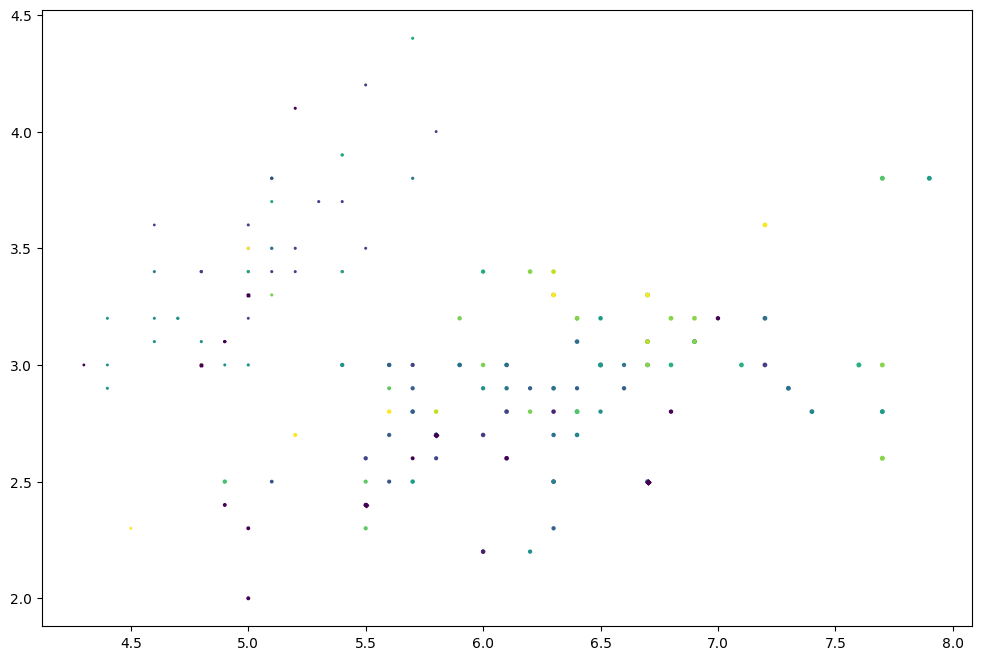

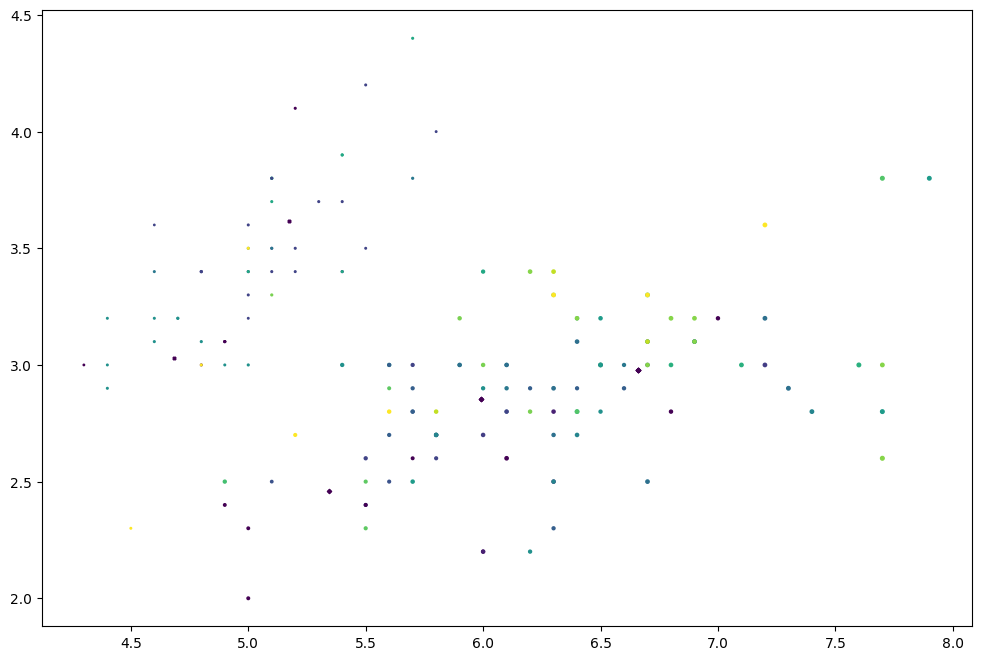

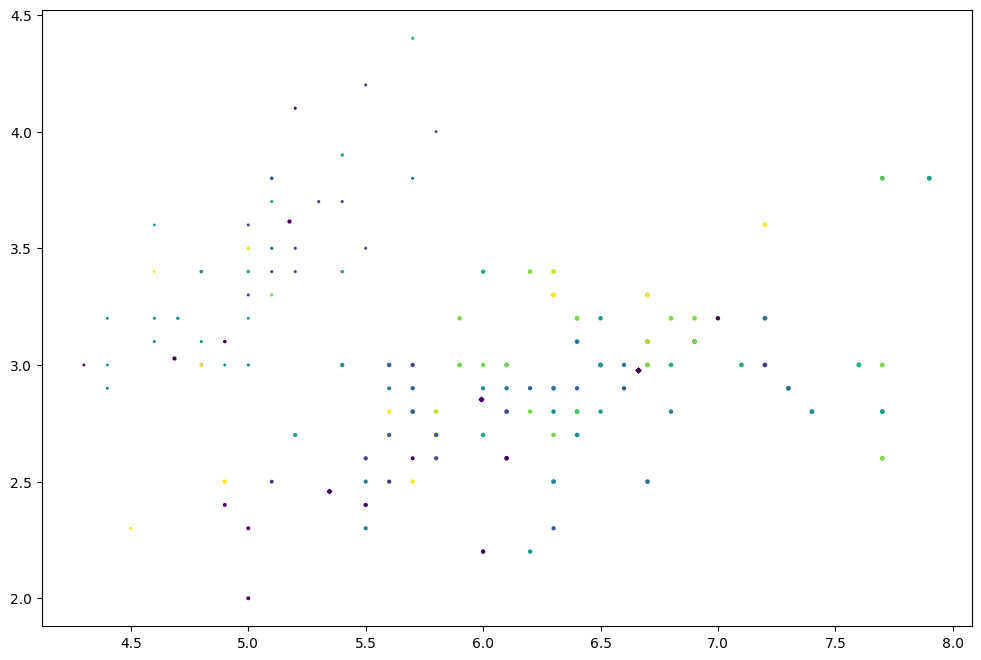

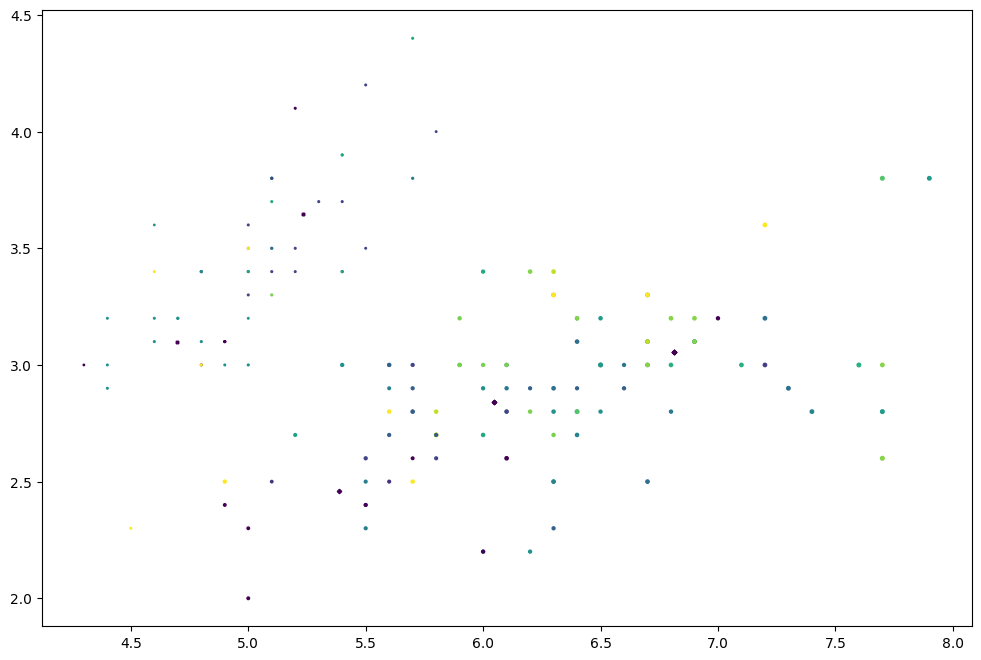

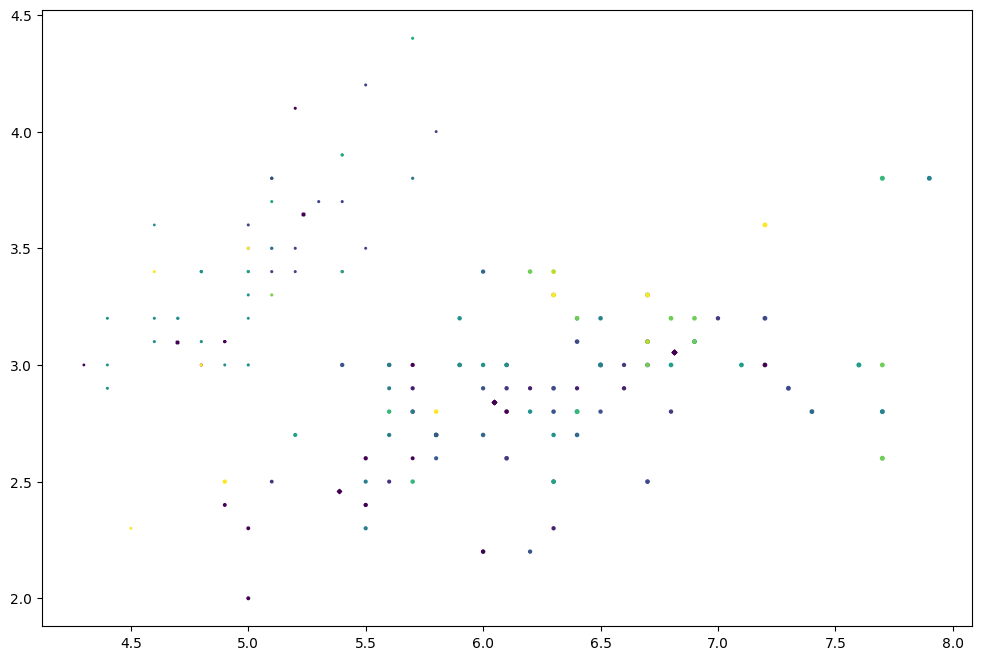

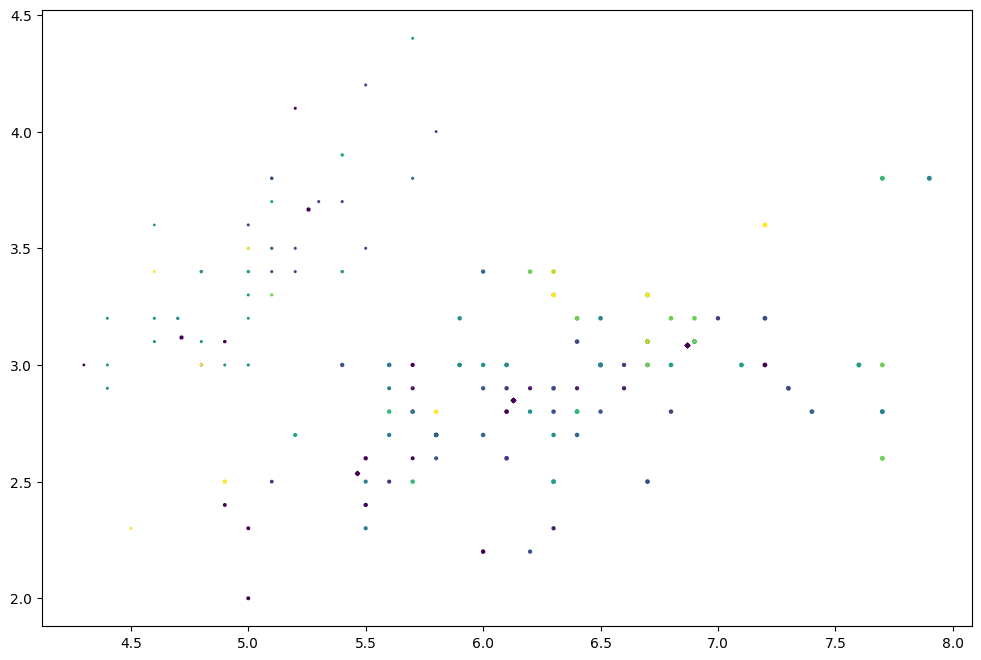

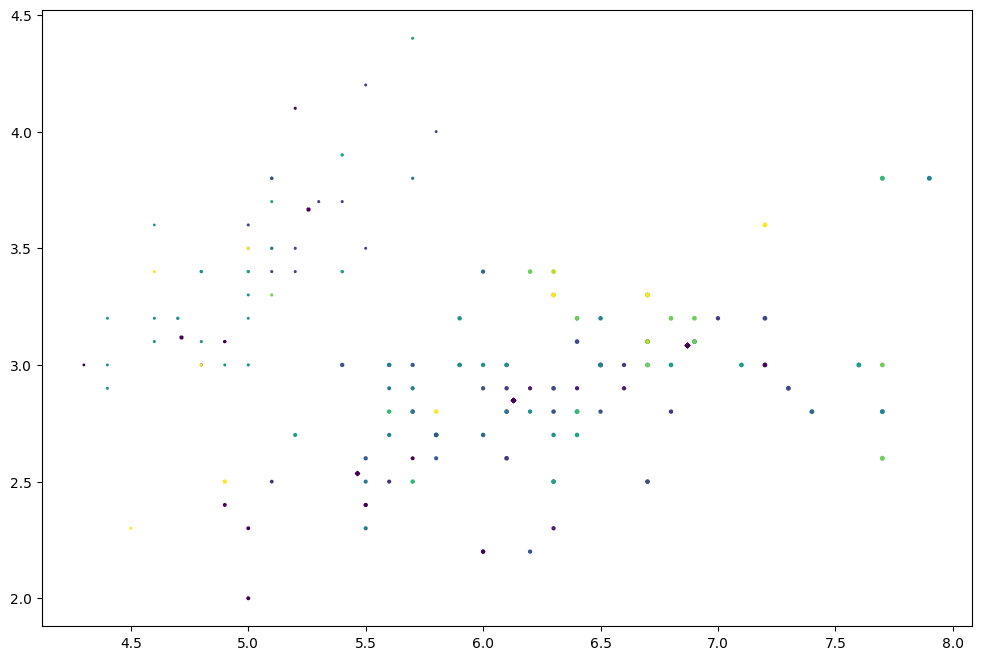

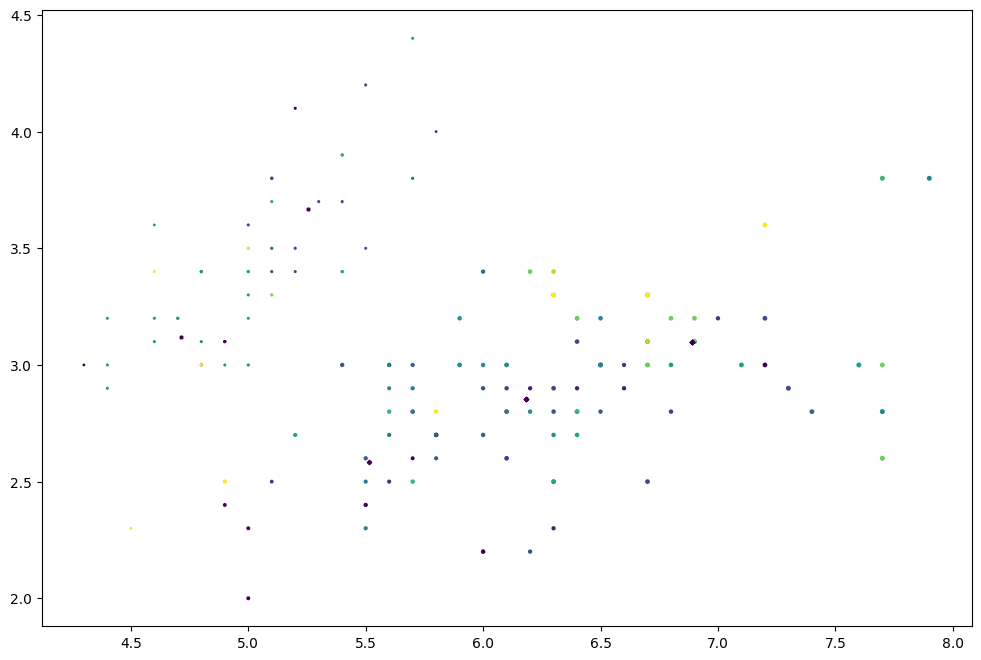

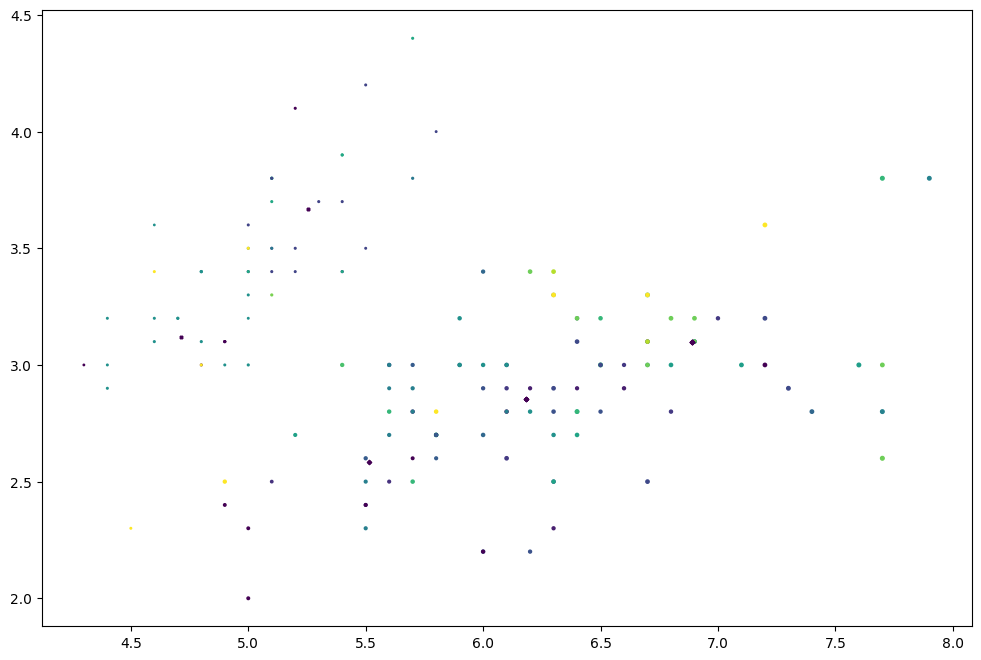

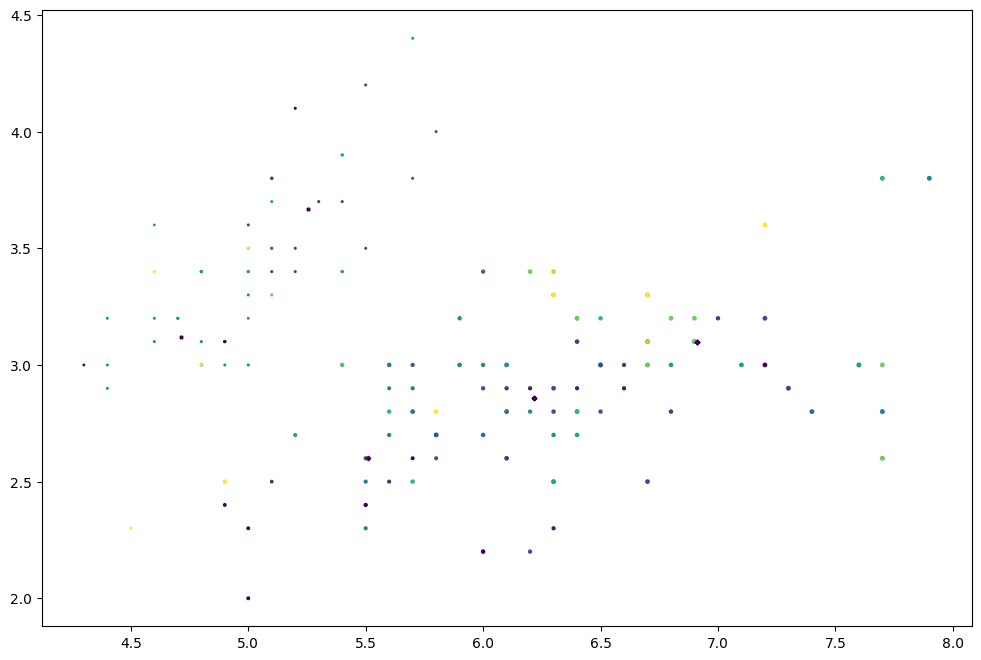

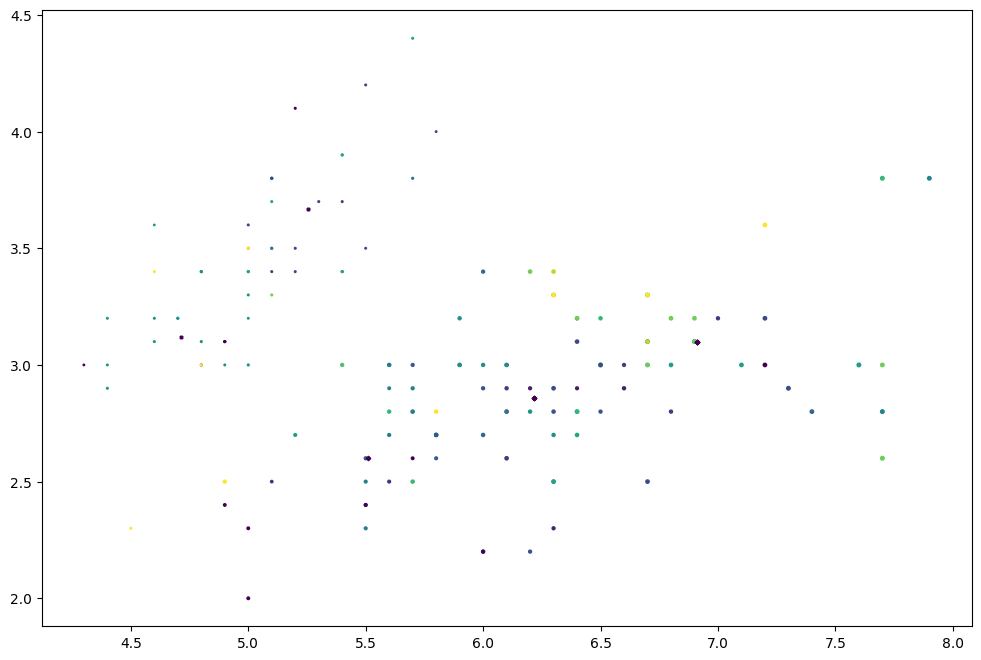

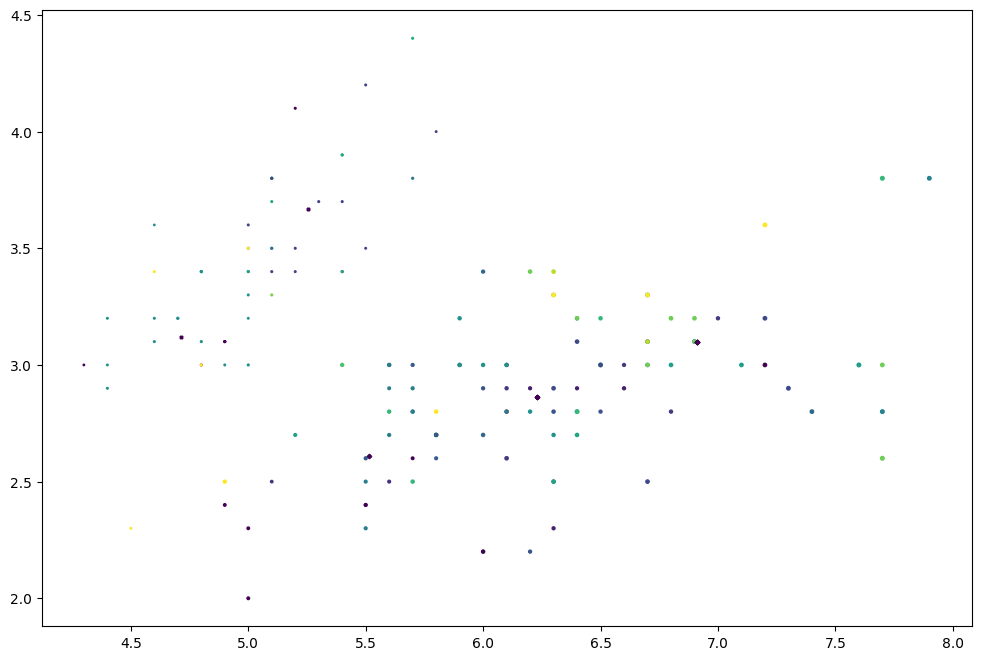

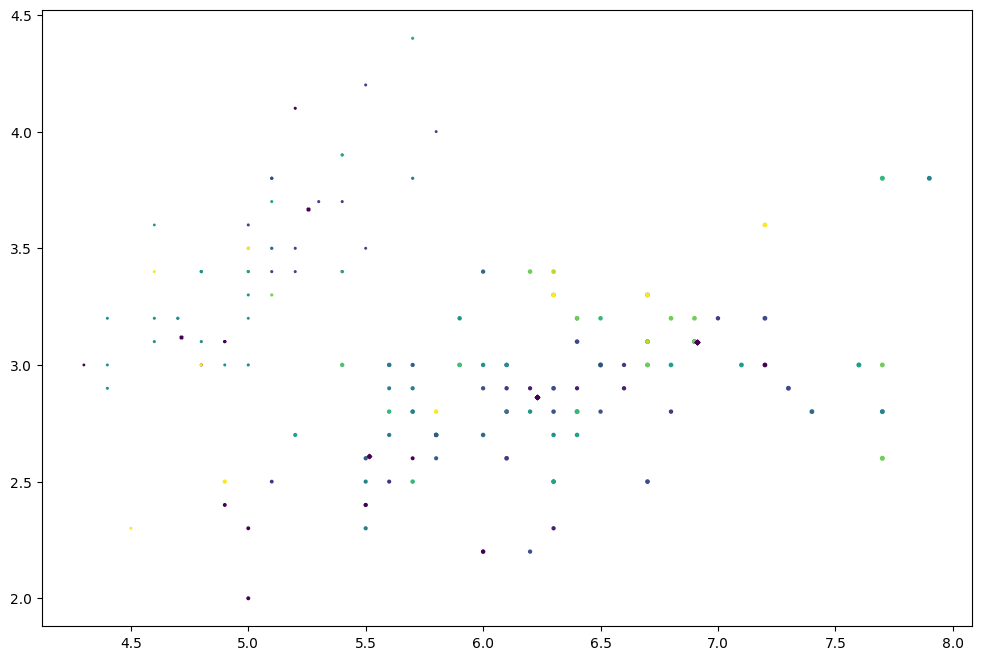

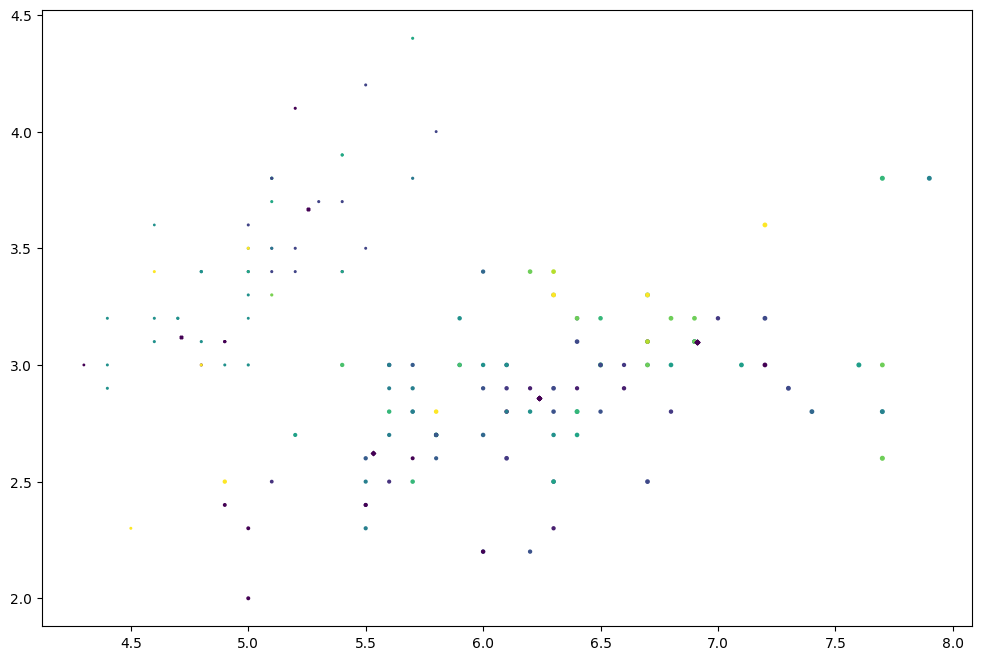

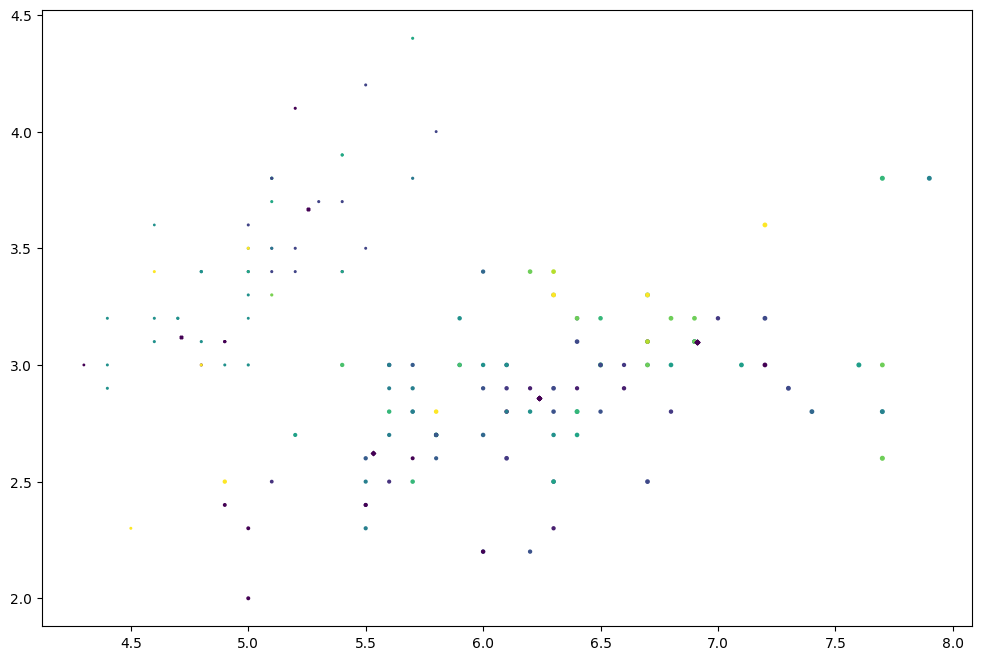

In [ ]:
prediction=model.predict(x)

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score = silhouette_score(x, prediction)
print(silhouette_score*100)

37.60483547874276
